# CNTK 207: Sampled Softmax

For classification and prediction problems a typical criterion function is cross-entropy with softmax. If the number of output classes is high the computation of this criterion and the corresponding gradients could be quite costly. Sampled Softmax is a heuristic to speed up training in these cases. (see: [Adaptive Importance Sampling to Accelerate Training of a Neural Probabilistic Language Model](http://www.iro.umontreal.ca/~lisa/pointeurs/importance_samplingIEEEtnn.pdf), [Exploring the Limits of Language Modeling](https://arxiv.org/pdf/1602.02410v1.pdf), [What is Candidate Sampling](https://www.tensorflow.org/extras/candidate_sampling.pdf))


#### Select the notebook runtime environment devices / settings

Before we dive into the details we run some setup that is required for automated testing of this notebook. 


In [1]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
from __future__ import division

import os
import cntk as C

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [2]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

## Basics

The softmax function is used in neural networks if we want to interpret the network output as a probability distribution over a set of classes $C$ with $|C|=N_C$.

Softmax maps an $N_C$-dimensional vector $z$, which has unrestricted values, to an $N_C$ dimensional vector $p$ with non-negative values that sum up to 1 so that they can be interpreted as probabilities. More precisely:

$$
\begin{align}
p_i &= softmax(z, i)\\
    &= \frac{exp(z_i)}{\sum_{k\in C} exp(z_k)}\\
\end{align}
$$

In what follows we assume that the input $z$ to the softmax is computed from some hidden vector $h$ of dimension $N_h$  in a specific way, namely:

$$ z = W h + b $$

where $W$ is a learnable weight matrix of dimension $(N_c, N_h)$ and $b$ is a learnable bias vector.
We restrict ourselves to this specific choice of $z$ because it helps in implementing an efficient sampled softmax.

In a typical use-case like for example a recurrent language model, the hidden vector $h$ would be the output of the recurrent layers and $C$ would be the set of words to predict.   

As a training criterion, we use cross-entropy which is a function of the expected (true) class $t\in C$ and the probability predicted for it:

$$cross\_entropy := -log(p_t)$$

## Sampled Softmax from the outside

For the normal softmax the CNTK Python-api provides the function [cross_entropy_with_softmax](https://cntk.ai/pythondocs/cntk.ops.html?highlight=softmax#cntk.ops.cross_entropy_with_softmax). This takes as input the $N_C$-dimensional vector $z$. As mentioned for our sampled softmax implementation we assume that this z is computed by $ z = W h + b $. In sampled softmax this has to be part of the whole implementation of the criterion.

Below we show the code for `cross_entropy_with_sampled_softmax_and_embedding`. Let’s look at the signature first.

One fundamental difference to the corresponding function in the Python-api (`cross_entropy_with_softmax`) is that in the Python api function the input corresponds to $z$ and must have the same dimension as the target vector, while in cross_entropy_with_full_softmax the input corresponds to our hidden vector $h$ can have any dimension (hidden_dim).
Actually, hidden_dim will be typically much lower than the dimension of the target vector.

We also have some additional parameters `num_samples, sampling_weights, allow_duplicates` that control the random sampling. 
Another difference to the api function is that we return a triple (z, cross_entropy_on_samples, error_on_samples).

We will come back to the details of the implementation below.

In [3]:



# Creates a subgraph computing cross-entropy with sampled softmax.
def cross_entropy_with_sampled_softmax_and_embedding(
    hidden_vector,            # Node providing hidden input
    target_vector,            # Node providing the expected labels (as sparse vectors)
    num_classes,              # Number of classes
    hidden_dim,               # Dimension of the hidden vector
    num_samples,              # Number of samples to use for sampled softmax
    sampling_weights,         # Node providing weights to be used for the weighted sampling
    allow_duplicates = True,  # Boolean flag to control whether to use sampling with replacemement 
                              # (allow_duplicates == True) or without replacement.
    ):
    # define the parameters learnable parameters
    b = C.Parameter(shape = (num_classes, 1), init = 0)
    W = C.Parameter(shape = (num_classes, hidden_dim), init = C.glorot_uniform())

    # Define the node that generates a set of random samples per minibatch
    # Sparse matrix (num_samples * num_classes)
    sample_selector = C.random_sample(sampling_weights, num_samples, allow_duplicates)

    # For each of the samples we also need the probablity that it in the sampled set.
    inclusion_probs = C.random_sample_inclusion_frequency(sampling_weights, num_samples, allow_duplicates) # dense row [1 * vocab_size]
    log_prior = C.log(inclusion_probs) # dense row [1 * num_classes]

    # Create a submatrix wS of 'weights
    W_sampled = C.times(sample_selector, W) # [num_samples * hidden_dim]
    z_sampled = C.times_transpose(W_sampled, hidden_vector) + C.times(sample_selector, b) - C.times_transpose (sample_selector, log_prior)# [num_samples]

    # Getting the weight vector for the true label. Dimension hidden_dim
    W_target = C.times(target_vector, W) # [1 * hidden_dim]
    z_target = C.times_transpose(W_target, hidden_vector) + C.times(target_vector, b) - C.times_transpose(target_vector, log_prior) # [1]


    z_reduced = C.reduce_log_sum_exp(z_sampled)
    
    # Compute the cross entropy that is used for training.
    # We don't check whether any of the classes in the random samples conincides with the true label, so it might
    # happen that the true class is counted
    # twice in the normalising demnominator of sampled softmax.
    cross_entropy_on_samples = C.log_add_exp(z_target, z_reduced) - z_target

    # For applying the model we also output a node providing the input for the full softmax
    z = C.times_transpose(W, hidden_vector) + b
    z = C.reshape(z, shape = (num_classes))

    zSMax = C.reduce_max(z_sampled)
    error_on_samples = C.less(z_target, zSMax)
    return (z, cross_entropy_on_samples, error_on_samples)




To give a better idea of what the inputs and outputs are and how this all differs from the normal softmax we give below a corresponding function using normal softmax:

In [4]:
# Creates subgraph computing cross-entropy with (full) softmax.
def cross_entropy_with_softmax_and_embedding(
    hidden_vector,  # Node providing hidden input
    target_vector,  # Node providing the expected labels (as sparse vectors)
    num_classes,    # Number of classes
    hidden_dim      # Dimension of the hidden vector
    ):
    # Setup bias and weights
    b = C.Parameter(shape = (num_classes, 1), init = 0)
    W = C.Parameter(shape = (num_classes, hidden_dim), init = C.glorot_uniform())

    
    z = C.reshape( C.times_transpose(W, hidden_vector) + b, (1, num_classes))
    
    # Use cross_entropy_with_softmax
    cross_entropy = C.cross_entropy_with_softmax(z, target_vector)

    zMax = C.reduce_max(z)
    zT = C.times_transpose(z, target_vector)
    error_on_samples = C.less(zT, zMax)

    return (z, cross_entropy, error_on_samples)

As you can see the main differences to the api function `cross_entropy_with_softmax` are:
* We include the mapping $ z = W h + b $ into the function.
* We return a triple (z, cross_entropy, error_on_samples) instead of just returning the cross entropy.


## A toy example

To explain how to integrate sampled softmax let us look at a toy example. In this toy example we first transform one-hot input vectors via some random projection into a lower dimensional vector $h$. The modeling task is to reverse this mapping using (sampled) softmax. Well, as already said this is a toy example.


In [5]:
import numpy as np
from math import log, exp, sqrt
from cntk.logging import ProgressPrinter
import timeit


# A class with all parameters
class Param:
    # Learning parameters
    learning_rate = 0.03
    minibatch_size = 100
    num_minbatches = 100
    test_set_size = 1000
    momentum_time_constant = 5 * minibatch_size
    reporting_interval = 10
    allow_duplicates = False
    
    # Parameters for sampled softmax
    use_sampled_softmax = True
    use_sparse = True
    softmax_sample_size = 10

    # Details of data and model
    num_classes = 50
    hidden_dim = 10
    
data_sampling_distribution = lambda: np.repeat(1.0 / Param.num_classes, Param.num_classes)
    
softmax_sampling_weights = lambda: np.repeat(1.0 / Param.num_classes, Param.num_classes)


# Creates random one-hot vectors of dimension 'num_classes'.
# Returns a tuple with a list of one-hot vectors, and list with the indices they encode.
def get_random_one_hot_data(num_vectors):
    indices = np.random.choice(
        range(Param.num_classes),
        size=num_vectors, 
        p = data_sampling_distribution()).reshape((num_vectors, 1))
    list_of_vectors = C.Value.one_hot(indices, Param.num_classes)
    return (list_of_vectors, indices.flatten())

# Create a network that:
# * Transforms the input one hot-vectors with a constant random embedding
# * Applies a linear decoding with parameters we want to learn
def create_model(labels):
    # random projection matrix
    random_data = np.random.normal(scale = sqrt(1.0/Param.hidden_dim), size=(Param.num_classes, Param.hidden_dim)).astype(np.float32)
    random_matrix = C.constant(shape = (Param.num_classes, Param.hidden_dim), value = random_data)
    
    h = C.times(labels, random_matrix)
    
    # Connect the latent output to (sampled/full) softmax.
    if Param.use_sampled_softmax:
        sampling_weights = np.asarray(softmax_sampling_weights(), dtype=np.float32)
        sampling_weights.reshape((1, Param.num_classes))
        softmax_input, ce, errs = cross_entropy_with_sampled_softmax_and_embedding(
            h, 
            labels,
            Param.num_classes, 
            Param.hidden_dim, 
            Param.softmax_sample_size, 
            softmax_sampling_weights(),
            Param.allow_duplicates)
    else:
        softmax_input, ce, errs = cross_entropy_with_softmax_and_embedding(
            h, 
            labels, 
            Param.num_classes, 
            Param.hidden_dim)

    return softmax_input, ce, errs

def train(do_print_progress):
    labels = C.input_variable(shape = Param.num_classes, is_sparse = Param.use_sparse)
    z, cross_entropy, errs = create_model(labels)

    # Setup the trainer
    learning_rate_schedule = C.learning_rate_schedule(Param.learning_rate, C.UnitType.sample)
    momentum_schedule = C.momentum_as_time_constant_schedule(Param.momentum_time_constant)
    learner = C.momentum_sgd(z.parameters, learning_rate_schedule, momentum_schedule, True)
    progress_writers = None
    if do_print_progress:
        progress_writers = [ProgressPrinter(freq=Param.reporting_interval, tag='Training')]
    trainer = C.Trainer(z, (cross_entropy, errs), learner, progress_writers)

    minbatch = 0
    average_cross_entropy = compute_average_cross_entropy(z)
    minbatch_data = [0] # store minibatch values
    cross_entropy_data = [average_cross_entropy] # store cross_entropy values

    # Run training
    t_total= 0

    # Run training
    for minbatch in range(1,Param.num_minbatches):
        # Specify the mapping of input variables in the model to actual minibatch data to be trained with
        label_data, indices = get_random_one_hot_data(Param.minibatch_size)
        arguments = ({labels : label_data})

        # If do_print_progress is True, this will automatically print the progress using ProgressPrinter
        # The printed loss numbers are computed using the sampled softmax criterion
        t_start = timeit.default_timer()
        trainer.train_minibatch(arguments)
        t_end = timeit.default_timer()

        t_delta = t_end - t_start
        samples_per_second = Param.minibatch_size / t_delta
        
        # We ignore the time measurements of the first two minibatches
        if minbatch > 2:
            t_total += t_delta

        # For comparison also print result using the full criterion
        if minbatch % Param.reporting_interval == int(Param.reporting_interval/2):
            # memorize the progress data for plotting
            average_cross_entropy = compute_average_cross_entropy(z)
            minbatch_data.append(minbatch)
            cross_entropy_data.append(average_cross_entropy)
            
            if do_print_progress:
                print("\nMinbatch=%d Cross-entropy from full softmax = %.3f perplexity = %.3f samples/s = %.1f"
                    % (minbatch, average_cross_entropy, exp(average_cross_entropy), samples_per_second))
                
    # Number of samples we measured. First two minbatches were ignored
    samples_measured = Param.minibatch_size * (Param.num_minbatches - 2)
    overall_samples_per_second = samples_measured / t_total
    return (minbatch_data, cross_entropy_data, overall_samples_per_second) 

def compute_average_cross_entropy(softmax_input):
    vectors, indices = get_random_one_hot_data(Param.test_set_size)
    total_cross_entropy = 0.0
    arguments = (vectors)
    z = softmax_input.eval(arguments).reshape(Param.test_set_size, Param.num_classes)

    for i in range(len(indices)):
        log_p = log_softmax(z[i], indices[i])
        total_cross_entropy -= log_p

    return total_cross_entropy / len(indices)

# Computes log(softmax(z,index)) for a one-dimensional numpy array z in an numerically stable way.
def log_softmax(z,    # numpy array
                index # index into the array
            ):
    max_z = np.max(z)
    return z[index] - max_z - log(np.sum(np.exp(z - max_z)))



np.random.seed(1)

print("start...")
train(do_print_progress = True)
print("done.")

start...
Learning rate per sample: 0.03
Momentum per sample: 0.9980019986673331

Minbatch=5 Cross-entropy from full softmax = 3.888 perplexity = 48.807 samples/s = 7652.9
 Minibatch[   1-  10]: loss = 2.389856 * 1000, metric = 89.10% * 1000;

Minbatch=15 Cross-entropy from full softmax = 3.528 perplexity = 34.042 samples/s = 8891.7
 Minibatch[  11-  20]: loss = 2.062891 * 1000, metric = 54.30% * 1000;

Minbatch=25 Cross-entropy from full softmax = 3.103 perplexity = 22.271 samples/s = 8691.4
 Minibatch[  21-  30]: loss = 1.720161 * 1000, metric = 37.20% * 1000;

Minbatch=35 Cross-entropy from full softmax = 2.823 perplexity = 16.823 samples/s = 8585.7
 Minibatch[  31-  40]: loss = 1.488539 * 1000, metric = 27.60% * 1000;

Minbatch=45 Cross-entropy from full softmax = 2.492 perplexity = 12.085 samples/s = 8477.3
 Minibatch[  41-  50]: loss = 1.219984 * 1000, metric = 10.80% * 1000;

Minbatch=55 Cross-entropy from full softmax = 2.292 perplexity = 9.892 samples/s = 7757.4
 Minibatch[  51

In the above code we use two different methods to report training progress:
1. Using a function that computes the average cross entropy on full softmax.
2. Using the built-in ProgressPrinter

ProgressPrinter reports how the value of the training criterion changes over time.
In our case the training criterion is cross-entropy from **sampled** softmax.
The same is true for the error rate computed by progress printer, this is computed only for true-class vs sampled-classes and will therefore underestimate the true error rate.

Therefore while ProgressPrinter already gives us some idea how training goes on, if we want to compare the behavior for different sampling strategies (sample size, sampling weights, ...) we should not rely on numbers that are computed only using the sampled subset of classes. 


## Importance sampling

Often the we don't have uniform distribution for the classes on the output side. The typical example is when we have words as output classes. A typical example are words where e.g. 'the' will be much more frequent than most others.

In such cases one often uses a non uniform distribution for drawing the samples in sampled softmax but instead increases the sampling weight for the frequent classes. This is also called importane sampling.
In our example the sampling distribution is controlled by the weight array `softmax_sampling_weights`.

As an example let's look at the case where the classes are distrubted according to zipf-distrubtion like:
$$
p[i] \propto \frac{1}{i+5},
$$
actually we use this distribution already in our example.

How does training behavior change if we switch uniform sampling to sampling with the zipfian distribution in sampled softmax?







start...


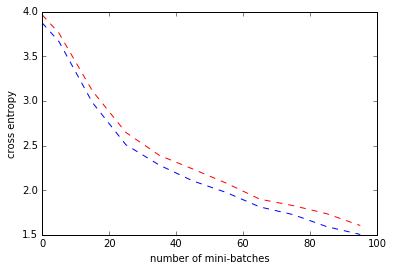

In [6]:
# We want to lot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# Define weights of zipfian distributuion
def zipf(index):
    return 1.0 / (index + 5)

# Use zipifian distribution for the classes
def zipf_sampling_weights():
    return np.asarray([ zipf(i) for i in range(Param.num_classes)], dtype=np.float32)

data_sampling_distribution = lambda: zipf_sampling_weights() / np.sum(zipf_sampling_weights())

print("start...")


# Train using uniform sampling (like before)
np.random.seed(1)
softmax_sampling_weights = lambda: np.repeat(1.0/Param.num_classes, Param.num_classes)
minibatch_data, cross_entropy_data, _ = train(do_print_progress = False)

# Train using importance sampling
np.random.seed(1)
softmax_sampling_weights = zipf_sampling_weights
minibatch_data2, cross_entropy_data2, _ = train(do_print_progress = False)

plt.plot(minibatch_data, cross_entropy_data, 'r--',minibatch_data, cross_entropy_data2, 'b--')
plt.xlabel('number of mini-batches')
plt.ylabel('cross entropy')
plt.show()



In the example above we compare uniform sampling (red) vs sampling with the same distribution the classes have (blue).
You will need to experiment to find the best settings for all the softmax parameters.


## What speedups to expect?

The speed difference between full softmax and sampled softmax in terms of training instances depends strongly on the concrete settings, namely
* Number of classes. Typically the speed-up will increase the more output classes you have.
* Number of samples used in sampled softmax
* Dimension of hiddlen layer input
* Minibatch size
* Hardware

Also you need to test how much you can reduce sample size without degradation of the result.

start...
Measuring speed of sampled softmax for sample size 5 ...
Measuring speed of sampled softmax for sample size 10 ...
Measuring speed of sampled softmax for sample size 100 ...
Measuring speed of sampled softmax for sample size 1000 ...
Measuring speed of full softmax ...


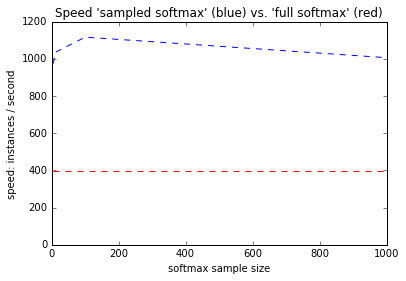

In [7]:
print("start...")

# Reset parameters
class Param:
    # Learning parameters
    learning_rate = 0.03
    minibatch_size = 8
    num_minbatches = 100
    test_set_size = 1 # we are only interrested in speed
    momentum_time_constant = 5 * minibatch_size
    reporting_interval = 1000000 # Switch off reporting to speed up
    allow_duplicates = False
    
    # Parameters for sampled softmax
    use_sampled_softmax = True
    use_sparse = True
    softmax_sample_size = 10

    # Details of data and model
    num_classes = 50000
    hidden_dim = 10
    
data_sampling_distribution = lambda: np.repeat(1.0 / Param.num_classes, Param.num_classes)
softmax_sampling_weights = lambda: np.repeat(1.0 / Param.num_classes, Param.num_classes)

    
sample_sizes = [5, 10, 100, 1000]
speed_with_sampled_softmax = []

# Get the speed with sampled softmax for different sizes
for sample_size in sample_sizes: 
    print("Measuring speed of sampled softmax for sample size %d ..." % (sample_size))
    Param.use_sampled_softmax = True
    Param.softmax_sample_size = sample_size
    _, _,  samples_per_second = train(do_print_progress = False)
    speed_with_sampled_softmax.append(samples_per_second)

# Get the speed with full softmax
Param.use_sampled_softmax = False
print("Measuring speed of full softmax ...")
_, _,  samples_per_second = train(do_print_progress = False)
speed_without_sampled_softmax = np.repeat(samples_per_second, len(sample_sizes))

# Plot the speed of sampled softmax (blue) as a function of sample sizes
# and compare it to the speed with full softmax (red).    
plt.plot(sample_sizes, speed_without_sampled_softmax, 'r--',sample_sizes, speed_with_sampled_softmax, 'b--')
plt.xlabel('softmax sample size')
plt.ylabel('speed: instances / second')
plt.title("Speed 'sampled softmax' (blue) vs. 'full softmax' (red)")
plt.ylim(ymin=0)
plt.show()
